#Image Segmentation of birds in the sky
In this notebook, we'll work on the task of image segmentation, specifically segmenting birds in the sky. Image segmentation involves dividing an image into multiple segments, with the goal of changing the representation of an image into something more meaningful and easier to analyze. Our target here is to separate the birds from the background.

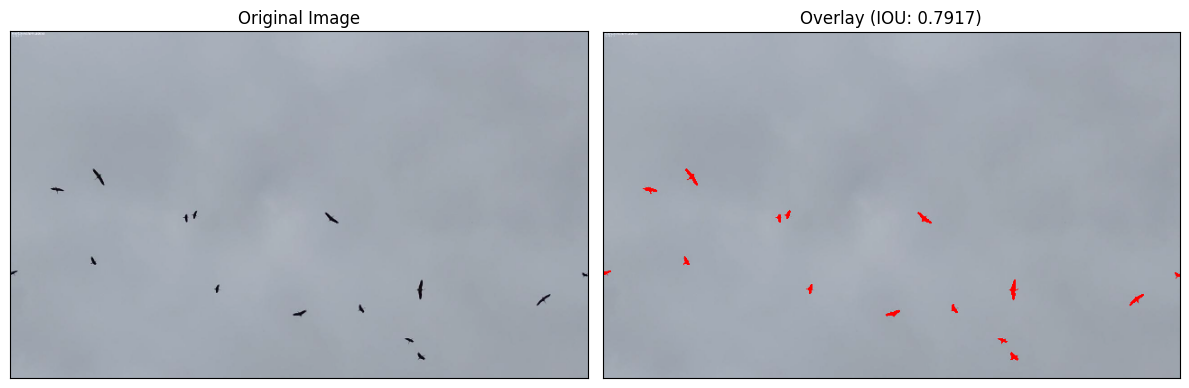

The steps we'll follow are:


**1. Environment Setup:** Import necessary libraries and configure the environment.

**2. Data Loading:** Define classes and functions to load and preprocess the data.

**3. Data Augmentation:** Set up data augmentation techniques to improve model generalization.

**4. Model Creation:** Define the neural network model for segmentation.

**5. Training:** Train the model on the dataset.

**6. Evaluation:** Evaluate the model's performance on a test set.

**7. Visualization:** Visualize some test samples, their ground truth masks, and the predicted masks.

**8.** Using all above as pipeline in main

**9.** Checking prediction for random test image










In [1]:
# 0. Unzip zip file with data if not ready yet
%system unzip birds_splitted.zip

["'unzip' is not recognized as an internal or external command,",
 'operable program or batch file.']

##If unzip does not work, unzip it manually. Be aware of nested folders, make it birds_splitted/(train|val|test)

In [ ]:
# 0. Install requirements if not ready yet
%system pip install tensorflow albumentations opencv-python segmentation-models


In [ ]:
# 0.5 Checking for GPU
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [ ]:

# 1. Environment Setup

# Importing necessary libraries
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import numpy as np
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from sklearn.preprocessing import normalize
from tensorflow import keras
from keras.utils import Sequence
import segmentation_models as sm

# Setting the segmentation models framework to use TensorFlow's Keras
sm.set_framework('tf.keras')


Segmentation Models: using `tf.keras` framework.



### 2. Data Loading

We'll define a `Dataset` class to handle the loading and preprocessing of images and their corresponding masks. This class will make it easier to fetch batches of data during training. Additionally, the `Dataloder` class will facilitate fetching batches of data during training.


In [ ]:
# 2. Data Loading

class Dataset:
    """
    A class to load and preprocess images and their corresponding masks.
    """

    def __init__(self, images_dir, masks_dir, augmentation=None, preprocessing=None):
        """
        Constructor for Dataset class.

        Parameters:
        - images_dir: Directory containing the images.
        - masks_dir: Directory containing the corresponding masks.
        - augmentation: (Optional) Augmentations to be applied.
        - preprocessing: (Optional) Preprocessing functions to be applied.
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.augmentation = augmentation
        self.preprocessing = preprocessing

        # Sort filenames to ensure they're loaded in the same order
        self.images_filenames = sorted(os.listdir(images_dir))
        self.masks_filenames = sorted(os.listdir(masks_dir))

        # Ensure that the number of images and masks are the same
        assert len(self.images_filenames) == len(self.masks_filenames), \
            "Number of images and masks should be the same!"


    def __getitem__(self, i):
        """
        Get a pair of preprocessed image and mask based on the index.

        Parameters:
        - i: Index of the image-mask pair.

        Returns:
        - Processed image and mask.
        """
        # Load image and mask
        image = cv2.imread(os.path.join(self.images_dir, self.images_filenames[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(self.masks_dir, self.masks_filenames[i]), 0)


        # Binary thresholding on the mask
        _, mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)

        # Convert image and mask to float32 type
        image = np.float32(image)
        mask = np.float32(mask)

        # Reshape the mask if it doesn't have a last dimension of size 1
        if mask.shape[-1] != 1:
            mask = np.reshape(mask, (*mask.shape, 1))

        # Apply augmentations and preprocessing if provided
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        """
        Returns the total number of image-mask pairs in the dataset.
        """
        return len(self.masks_filenames)


class Dataloder(Sequence):
    """
    A class to form batches from the dataset.
    """

    def __init__(self, dataset, batch_size=1):
        """
        Constructor for Dataloder class.

        Parameters:
        - dataset: Instance of the Dataset class.
        - batch_size: Size of batches to be formed.
        """
        self.dataset = dataset
        self.batch_size = batch_size

    def __getitem__(self, i):
        """
        Get a batch of data based on the index.

        Parameters:
        - i: Index of the batch.

        Returns:
        - A batch of image-mask pairs.
        """
        data = [self.dataset[j] for j in range(i*self.batch_size, min((i+1)*self.batch_size, len(self.dataset)))]
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        return batch

    def __len__(self):
        """
        Returns the total number of batches that can be formed from the dataset.
        """
        return len(self.dataset) // self.batch_size




### 3. Data Augmentation and Preprocessing

In this section, we'll set up data augmentation techniques to improve the model's ability to generalize across various forms of input data. Additionally, we'll establish preprocessing routines to prepare the data for the model. This involves normalizing the data, resizing, and other necessary transformations.


In [ ]:
# 3. Data Augmentation and Preprocessing

def round_clip_0_1(x, **kwargs):
    """
    Rounds the values of an image and clips them to the range [0, 1].
    """
    return x.round().clip(0, 1)

def get_training_augmentation():
    """
    Returns a list of augmentations to be applied during training.
    """
    train_transform = [
        A.Resize(384, 640),
        A.PadIfNeeded(min_height=384, min_width=640),  # Use either min_height/min_width or pad_height_divisor/pad_width_divisor
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

def get_validation_augmentation():
    """
    Returns augmentations for validation data.
    """
    test_transform = [
        A.Resize(384, 640),
        A.PadIfNeeded(min_height=384, min_width=640)  # Use either min_height/min_width or pad_height_divisor/pad_width_divisor
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """
    Returns the preprocessing function for images.
    """
    return A.Compose([A.Lambda(image=preprocessing_fn)])



### 4. Model Creation

In this section, we'll define our neural network model for segmentation. We'll be using the U-Net architecture with an "efficientnetb3" backbone. This architecture is widely used for image segmentation tasks due to its ability to capture spatial hierarchies effectively.

We'll also define the optimizer, loss function, and metrics that will be used during training and evaluation.


In [ ]:
# 4. Model Creation

def create_model():
    """
    Creates and returns the U-Net model with an 'efficientnetb3' backbone.
    """
    # Create U-Net model
    model = sm.Unet('efficientnetb3', encoder_weights='imagenet', classes=1, activation='sigmoid')

    # Define the optimizer, loss function, and metrics
    optimizer = keras.optimizers.Adam(0.0001)
    loss = sm.losses.bce_jaccard_loss
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model



### 5. Training

We'll define functions to train our model. Training involves feeding our data into the model, adjusting the model's weights based on the computed loss, and monitoring metrics like IOU Score to understand how well our model is performing.

For improved training dynamics, we'll also set up callbacks. Callbacks are functionalities that can be added to the training loop, such as saving the model weights when performance improves or adjusting the learning rate when progress plateaus.


In [19]:
# 5. Training
from sklearn.metrics import jaccard_score


def train_model(model, train_dataloader, valid_dataloader, epochs, test_dataset):
    """
    Train the model on the given data.

    Parameters:
    - model: The segmentation model.
    - train_dataloader: Dataloader for training data.
    - valid_dataloader: Dataloader for validation data.
    - epochs: Number of training epochs.

    Returns:
    - Training history.
    """
    # Define callbacks for training
    PREDICTION_SAVE_DIR = "/predictions/"
    callbacks = [
    # Save best model to Google Drive
      keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=False, save_best_only=True, mode='min'),
      keras.callbacks.ReduceLROnPlateau(),
      # Custom callback to save prediction images to Google Drive after every epoch
      keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: save_prediction_callback(epoch, logs, test_dataset, model, PREDICTION_SAVE_DIR)),
      # Early stopping
      keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
      ]

    # Train the model
    history = model.fit(
        train_dataloader,
        steps_per_epoch=len(train_dataloader),
        epochs=epochs,
        callbacks=callbacks,
        validation_data=valid_dataloader,
        validation_steps=len(valid_dataloader),
        verbose=1
    )

    return history



### 6. Evaluation

Once the model is trained, it's essential to evaluate its performance on unseen data to understand how well it generalizes. This step will involve using our trained model to make predictions on a test dataset and then computing relevant metrics (like IOU Score) to measure the accuracy of these predictions.

We'll also visualize the training history to see how the model's performance progressed over the epochs.


In [ ]:
# 6. Evaluation

def plot_training_history(history):
    """
    Plot the training history, showing the IOU Score and Loss over epochs.

    Parameters:
    - history: Training history returned by the model.fit function.
    """
    plt.figure(figsize=(30, 5))

    # Plotting IOU Score
    plt.subplot(121)
    plt.plot(history.history['iou_score'])
    plt.plot(history.history['val_iou_score'])
    plt.title('Model IOU Score')
    plt.ylabel('IOU Score')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.ylim([0, 1])

    # Plotting Loss
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.savefig("history.png")
    plt.show()



### 7. Visualization

To get a more intuitive understanding of our model's performance, we'll visualize some predictions. This will involve taking a few test images, using our model to predict the masks, and then displaying the original images, the true masks, and the predicted masks side by side for comparison.


In [20]:
# 7. Visualization
import random
from sklearn.metrics import jaccard_score

def compute_iou(mask_true, mask_pred):
    """Compute the Intersection over Union (IoU) score."""
    mask_true = mask_true.flatten() > 0.5
    mask_pred = mask_pred.flatten() > 0.5
    return jaccard_score(mask_true, mask_pred)

# Needed for bug fix, original image results with noise without that
def rescale_image(image):
    """Rescale the image values to the [0, 255] range."""
    image = ((image - image.min()) * (1/(image.max() - image.min()) * 255)).astype('uint8')
    return image

def visualize(image, overlay, iou_score):
    """Plot the given images side by side."""
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.xticks([])
    plt.yticks([])
    plt.title("Original Image")
    plt.imshow(rescale_image(image), cmap='gray')

    plt.subplot(1, 2, 2)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Overlay (IOU: {iou_score:.4f})")
    plt.imshow(overlay, cmap='gray')

    plt.tight_layout()
    plt.show()


def overlay_mask_on_image(image, mask):
    """Overlay the mask on the image with semi-transparent red color."""
    overlay = image.copy()
    red_mask = (mask.squeeze() > 0.5).astype(np.uint8)  # Convert prediction to binary mask
    overlay[:, :, 0] = np.where(red_mask == 1, 255, image[:, :, 0])
    overlay[:, :, 1:3] = np.where(np.repeat(red_mask[:, :, np.newaxis], 2, axis=2) == 1, 0, image[:, :, 1:3])
    overlay = cv2.addWeighted(image.astype(np.uint8), 0.6, overlay.astype(np.uint8), 0.4, 0)
    return overlay

def visualize_predictions(dataset, model):
    """Visualize a random prediction of the model on the given dataset."""
    image, mask_true = random.choice(dataset)
    mask_pred = model.predict(np.expand_dims(image, axis=0))[0]

    # Compute overlay image
    overlay_image = rescale_image(image).copy()
    overlay_image[mask_pred.squeeze() > 0.5] = [255, 0, 0]  # Red color

    # Compute IOU score
    iou_score = compute_iou(mask_true, mask_pred)

    visualize(image=rescale_image(image.squeeze()), overlay=overlay_image, iou_score=iou_score)


# For training callback
def save_prediction_callback(epoch, logs, test_dataset, model, save_dir, n=3, threshold=0.5):
    """
    Custom callback function to save a grid of images: original image and
    the overlay (original image with the predicted mask) side by side.
    Also, annotates the overlay image with the epoch number and IOU score.
    """
    fig, axarr = plt.subplots(n, 2, figsize=(15, 5*n))

    for i in range(n):
        image, mask_true = random.choice(test_dataset)
        mask_pred = model.predict(np.expand_dims(image, axis=0))[0]
        predicted_mask_bin = (mask_pred[..., 0] > threshold).astype(np.uint8)

        # Compute IOU score
        iou_score = compute_iou(mask_true, mask_pred)

        # Visualize the source image
        axarr[i, 0].imshow(rescale_image(image.squeeze()))
        axarr[i, 0].axis('off')
        axarr[i, 0].set_title('Source Image')

        # Visualize the overlay image using the overlay_mask_on_image function
        overlay = overlay_mask_on_image(rescale_image(image.squeeze()), predicted_mask_bin)
        axarr[i, 1].imshow(overlay)
        axarr[i, 1].axis('off')
        axarr[i, 1].set_title(f'Epoch: {epoch+1}, IOU: {iou_score:.4f}')

    plt.tight_layout()
    filename = os.path.join(save_dir, f"results_epoch_{epoch+1}.png")
    plt.savefig(filename)
    plt.close(fig)

### 8. Main Function
Containing entire pipeline.





In [21]:


def main(BACKBONE='efficientnetb3', BATCH_SIZE=1, LR=0.0001, EPOCHS=40):
    # 1. Set Directories
    x_train_dir = '/birds_splitted/train/images'
    y_train_dir = '/birds_splitted/train/mask'
    x_valid_dir = '/birds_splitted/val/images'
    y_valid_dir = '/birds_splitted/val/mask'
    x_test_dir = '/birds_splitted/test/images'
    y_test_dir = '/birds_splitted/test/mask'

    # 2, 3. Load Data & Augmentation
    train_dataset = Dataset(x_train_dir, y_train_dir, augmentation=get_training_augmentation())
    valid_dataset = Dataset(x_valid_dir, y_valid_dir, augmentation=get_validation_augmentation())
    test_dataset = Dataset(x_test_dir, y_test_dir, augmentation=get_validation_augmentation())

    # 4. Data Loaders
    train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE)
    valid_dataloader = Dataloder(valid_dataset, batch_size=1)  # Validation batch size is kept as 1 for simplicity

    # 5. Model Creation
    model = create_model()


    # Update the learning rate of the model's optimizer
    model.optimizer.lr = LR

    # 6. Training
    history = train_model(model, train_dataloader, valid_dataloader, epochs=EPOCHS, test_dataset=test_dataset)

    # 7. Plot Training History on finish
    plot_training_history(history)

    # 8. Visualize Predictions on finish
    visualize_predictions(test_dataset, model)
    visualize_predictions(test_dataset, model)
    visualize_predictions(test_dataset, model)

# To execute the pipeline with custom configuration, you can call:
# main(BACKBONE='efficientnetb3', BATCH_SIZE=8, LR=0.0005, EPOCHS=50)


**Call the main to start training**

Epoch 1/10
1882/1882 [==============================] - ETA: 0s - loss: 0.6932 - iou_score: 0.6454 - f1-score: 0.7662

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1882/1882 [==============================] - 235s 91ms/step - loss: 0.6932 - iou_score: 0.6454 - f1-score: 0.7662 - val_loss: -14.1855 - val_iou_score: 8.8365 - val_f1-score: 1.7770 - lr: 1.0000e-04
Epoch 2/10
1882/1882 [==============================] - ETA: 0s - loss: 0.1824 - iou_score: 0.8353 - f1-score: 0.9095

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1882/1882 [==============================] - 167s 89ms/step - loss: 0.1824 - iou_score: 0.8353 - f1-score: 0.9095 - val_loss: -16.0177 - val_iou_score: 8.3230 - val_f1-score: 1.7621 - lr: 1.0000e-04
Epoch 3/10
1882/1882 [==============================] - ETA: 0s - loss: 0.1583 - iou_score: 0.8508 - f1-score: 0.9187

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1882/1882 [==============================] - 168s 89ms/step - loss: 0.1583 - iou_score: 0.8508 - f1-score: 0.9187 - val_loss: -20.0020 - val_iou_score: 10.2983 - val_f1-score: 1.8067 - lr: 1.0000e-04
Epoch 4/10
1882/1882 [==============================] - 161s 86ms/step - loss: 0.1499 - iou_score: 0.8571 - f1-score: 0.9224 - val_loss: -17.2985 - val_iou_score: 7.1946 - val_f1-score: 1.7368 - lr: 1.0000e-04
Epoch 5/10
1882/1882 [==============================] - 162s 86ms/step - loss: 0.1442 - iou_score: 0.8619 - f1-score: 0.9252 - val_loss: -16.6393 - val_iou_score: 6.2300 - val_f1-score: 1.6883 - lr: 1.0000e-04
Epoch 6/10
1882/1882 [==============================] - 163s 87ms/step - loss: 0.1404 - iou_score: 0.8653 - f1-score: 0.9271 - val_loss: -16.2015 - val_iou_score: 5.5421 - val_f1-score: 1.6650 - lr: 1.0000e-04
Epoch 7/10
1882/1882 [==============================] - ETA: 0s - loss: 0.1374 - iou_score: 0.8680 - f1-score: 0.9287

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1882/1882 [==============================] - 166s 88ms/step - loss: 0.1374 - iou_score: 0.8680 - f1-score: 0.9287 - val_loss: -22.0086 - val_iou_score: 9.5582 - val_f1-score: 1.7865 - lr: 1.0000e-04
Epoch 8/10
1882/1882 [==============================] - 164s 87ms/step - loss: 0.1352 - iou_score: 0.8700 - f1-score: 0.9299 - val_loss: -17.5999 - val_iou_score: 6.1440 - val_f1-score: 1.6888 - lr: 1.0000e-04
Epoch 9/10
1882/1882 [==============================] - 162s 86ms/step - loss: 0.1328 - iou_score: 0.8722 - f1-score: 0.9311 - val_loss: -18.9456 - val_iou_score: 6.5330 - val_f1-score: 1.7027 - lr: 1.0000e-04
Epoch 10/10
1882/1882 [==============================] - 161s 85ms/step - loss: 0.1312 - iou_score: 0.8737 - f1-score: 0.9320 - val_loss: -19.5393 - val_iou_score: 6.9188 - val_f1-score: 1.7112 - lr: 1.0000e-04


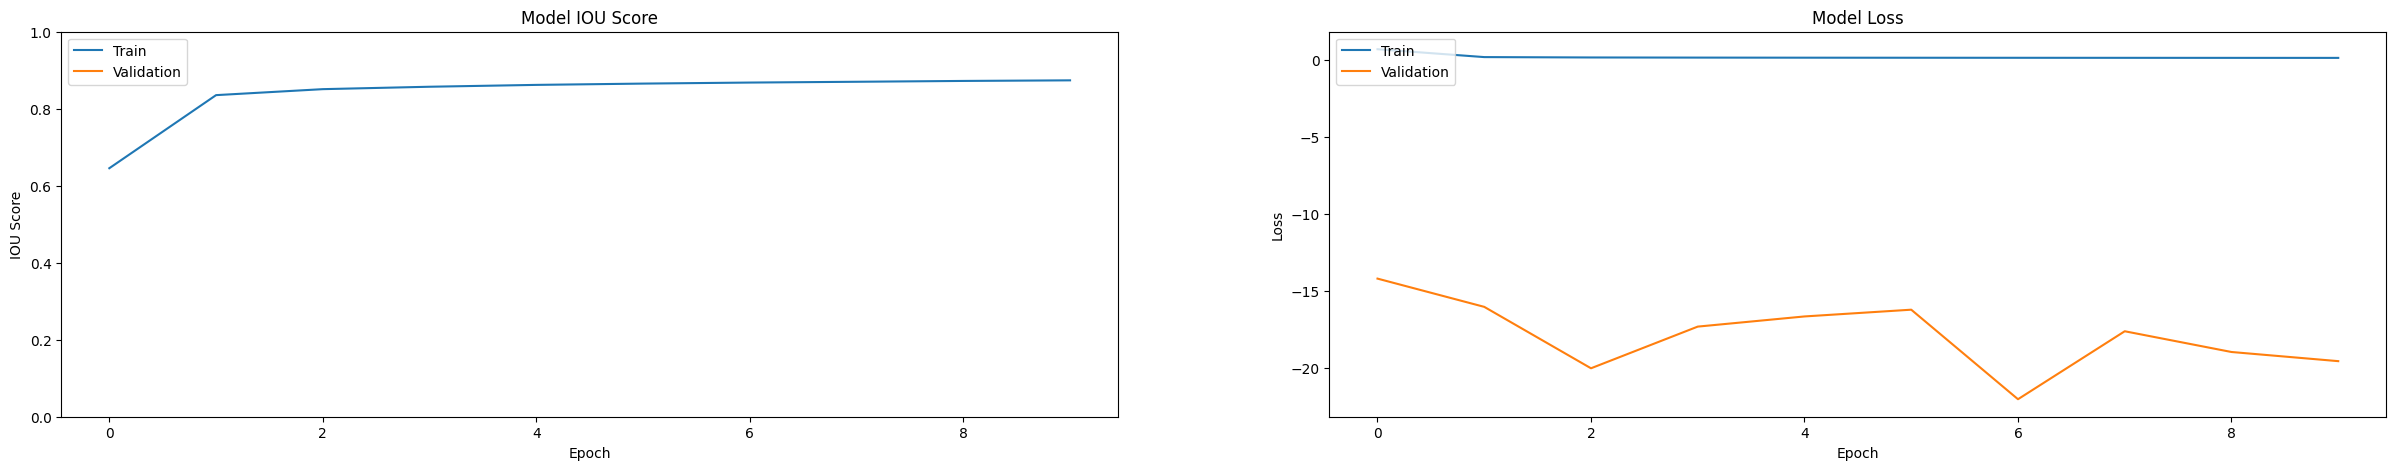

1/1 [==============================] - 0s 31ms/step


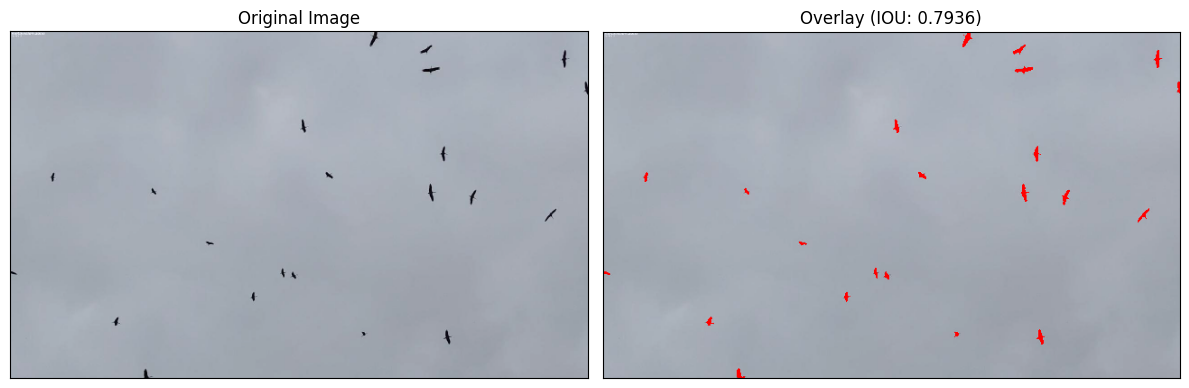

1/1 [==============================] - 0s 30ms/step


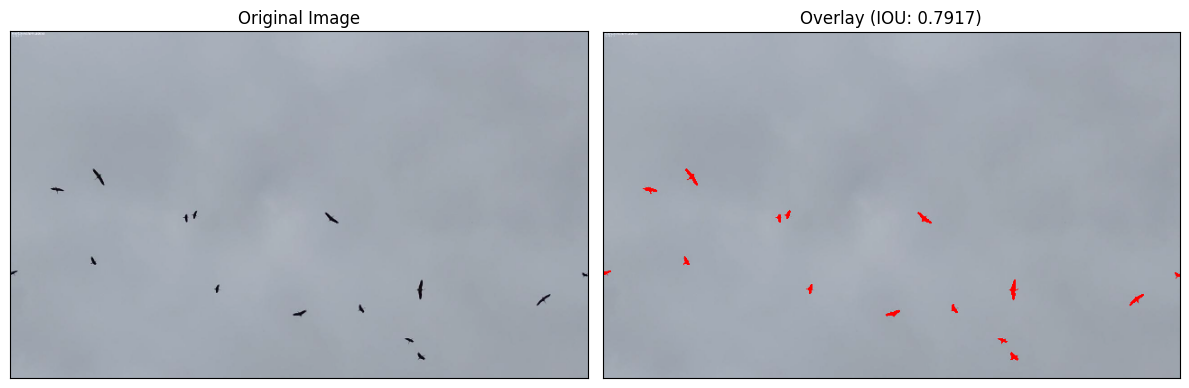

1/1 [==============================] - 0s 29ms/step


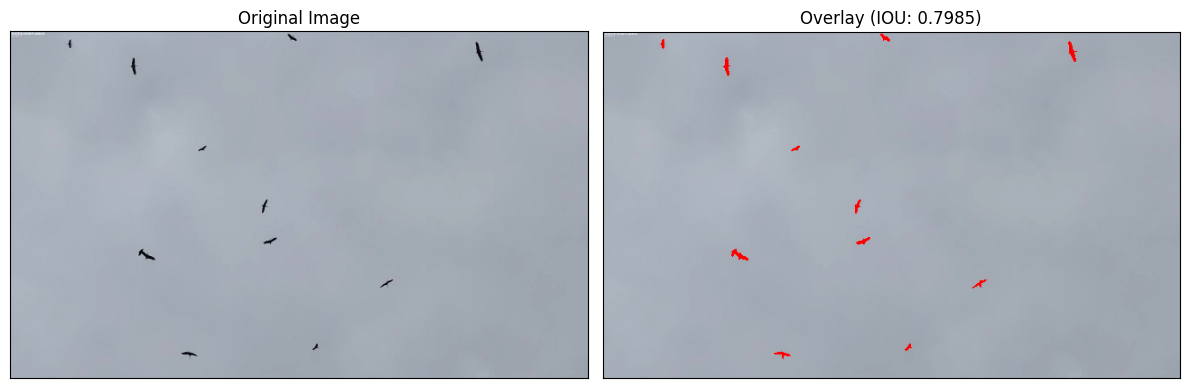

In [22]:
main(BACKBONE='efficientnetb3', BATCH_SIZE=1, LR=0.0001, EPOCHS=10) #Feel free to customize

**IF NOT TRAINING**

You can play with predictions here. But train your model first by running main(), mine is too big to upload.

In [ ]:

# Load test dataset
x_test_dir = '/birds_splitted/test/images'
y_test_dir = '/birds_splitted/test/mask'

test_dataset = Dataset(x_test_dir, y_test_dir, augmentation=get_validation_augmentation())

# Path to the saved model
MODEL_PATH = './best_model.h5'

model = create_model()
model.load_weights(MODEL_PATH)
visualize_predictions(test_dataset, model)
visualize_predictions(test_dataset, model)
visualize_predictions(test_dataset, model)
